# DIABETES LEARNING



In [1]:
isGoogleColab = True

# Notes

- check these blog posts: https://muellerzr.github.io/fastblog/ and his course: https://walkwithfastai.com/intro.contribute
- learner.export() already save all the transforms that will be applied during inference time, so it is not necessary to resize or normalize stats. If running outside the model outside fastai, check: https://forums.fast.ai/t/do-we-need-to-normalize-single-image-before-running-predict-function-on-it/44301/4
- to_fp16() is mixed precision
- item_tfms already apply the resize before collating the images in a batch. So it is not necessary to do this manually
- aug_tfms will only be applied on train_dl. validation and test will not be affected
- test_dl is a testing dataloader that uses the same transforms as train_dl and valid_dl, but with new data
- check images cleaner in the future
- cross validation: check walkwithfastai video 3 or https://forums.fast.ai/t/is-it-possible-to-implement-cross-validation-in-fastai/44961/15 or https://forums.fast.ai/t/am-i-doing-k-fold-cross-validation-right/84738/6  
- stratification in Kfold and Train_Test split for Multi Label problems is not straighforward. Check http://scikit.ml/index.html#. Use for now balanced datasets!!!!



# Installation

## Kill all other GPU sessions

Run the first time this cell. Then, restart your session and run again the notebook without this code.

In [2]:
  #!kill -9 -1

## Keep Session Alive

Put this javascript code in the browser console

In [3]:
# function ClickConnect(){
#    console.log("Working");
#    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
# }  setInterval(ClickConnect,300000)

## Update ipython/ipykernel (Colab)

The Colab session can fail when running the first time this cell. Just run it a second time.

In [4]:
# This magic cell should be put first in your colab notebook. 
# It'll automatically upgrade colab's really antique ipython/ipykernel to their 
# latest versions which are required for packages like ipyexperiments 

# from packaging import version
# import IPython, ipykernel
# IPython.__version__
# if version.parse(IPython.__version__) <= version.parse("5.5.0"):
#     !pip install -q --upgrade ipython
#     !pip install -q --upgrade ipykernel
    
#     import os
#     import signal
#     os.kill(os.getpid(), signal.SIGTERM)
# print(f"ipykernel=={ipykernel.__version__}")
# print(f"IPython=={IPython.__version__}")

In [5]:
# new (large)
# !pip install ipyexperiments
# new (large)
# from ipyexperiments import IPyExperimentsPytorch
# exp = IPyExperimentsPytorch()

## Check GPU e CPU RAM

In [6]:
if isGoogleColab:
    
    import torch
    from pynvml import *
    nvmlInit()
    def log_mem():
        h = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(h)
        print(f'GPU total Memory    : {info.total}')
        print(f'GPU free Memory     : {info.free}')
        print(f'GPU Memory used     : {info.used}')
    torch.ones(1).to(0)
    log_mem()

    !nvidia-smi

GPU total Memory    : 17071734784
GPU free Memory     : 16116350976
GPU Memory used     : 955383808
Mon Jul 19 17:26:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    38W / 250W |    911MiB / 16280MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------------

## Mount the Google Drive to Google Colab

In [7]:
if isGoogleColab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path_to_drive = "/content/drive/MyDrive/Colab Notebooks/"
    sys.path.append(path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/') #make src files importable

else:
    path_to_drive = "./"

Mounted at /content/drive


In [8]:
#!unrar x "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/augmentedDataset_v2.rar" "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/"
#!unrar x "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/augmentedDataset.rar" # extrai local
#!unzip "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/database.zip" -d "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/"
#!wget http://www.ivl.disco.unimib.it/download/http://www.ivl.disco.unimib.it/minisites/UNIMIB2016/UNIMIB2016-images.zip -P /content/drive/MyDrive/UnB/TCC/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB
#!unzip "/content/drive/MyDrive/UnB/TCC/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/UNIMIB2016-images.zip" -d "/content/drive/MyDrive/UnB/TCC/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/"

## Install Deep Learning libraries

In [9]:
# !pip install torch==1.7.1
# !pip install fastai==2.4.1
# !pip install wandb

##restart runtime!!!

In [10]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Pytorch: 1.9.0+cu102
Fastai: 2.4.1


# Train your model

In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
import torch
import torchvision
from PIL import Image
import wandb
wandb.login()

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: Currently logged in as: bunoviske (use `wandb login --relogin` to force relogin)


True

## Data

In [12]:
path = path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/' 
path_anno = path + 'gt/'
path_img = path + 'done/'

#funcao que pega a imagem de anotacoes correspondente, dado a imagem original de entrada
get_y_fn = lambda x : path_anno + '/' + f'{x.stem}GT.png'

In [13]:
np.random.seed(2) #mesma semente para todas as vezes que executar
randomSeed = 2

label_fnames = get_image_files(path_anno)
print(label_fnames[:3])
fnames = get_image_files(path_img)
print(fnames[:3])

len(fnames), len(label_fnames)

[Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/gt/20151127_121649GT.png'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/gt/20151127_121831GT.png'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/gt/20151127_121903GT.png')]
[Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151204_132033.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151204_132059.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151204_132116.jpg')]


(1027, 1027)

In [14]:
codes = np.loadtxt(path + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')
codes = list(codes)
len(codes)

74

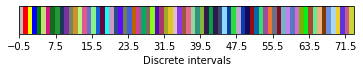

In [15]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(codes))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) # nao alimento -> cinza
cmaplist[1] = "red" # nao registrado
cmaplist[2] = "yellow" #arroz integral
cmaplist[3] = "blue" #arroz branco
cmaplist[4] = "green" #feijao

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(codes)+1)] # intervalos devem conter apenas o numero inteiro, entao ir de 0.5 em 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

(2448, 3264, 3)
(612, 816)


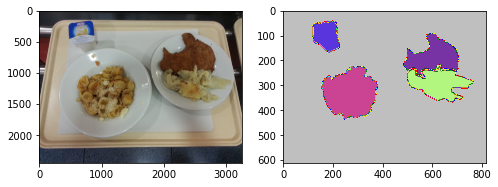

Ground truth Codes [ 0 10 13 26 71]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151204_132033.jpg
(2448, 3264, 3)
(612, 816)


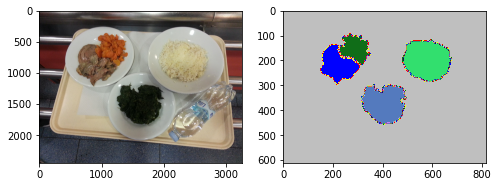

Ground truth Codes [ 0  3  7 53 60]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151204_132059.jpg
(2448, 3264, 3)
(612, 816)


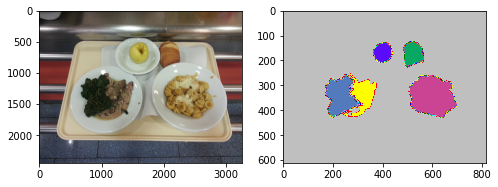

Ground truth Codes [ 0  2 22 26 27 60]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151204_132116.jpg
(2448, 3264, 3)
(612, 816)


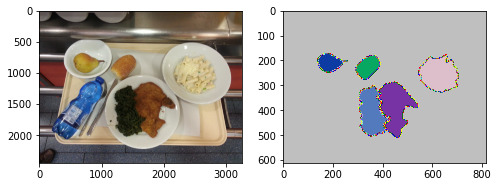

Ground truth Codes [ 0 10 27 34 46 60]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151204_132129.jpg
(2448, 3264, 3)
(612, 816)


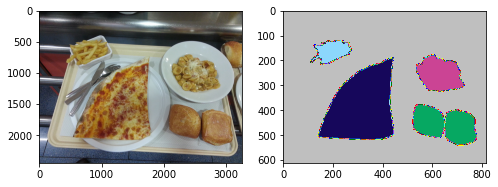

Ground truth Codes [ 0 26 27 45 50]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/done/20151204_132219.jpg


In [16]:
### VISUALIZACAO DA MÁSCARA FICA COM A BORDA ESTRANHA, MAS ELA ESTÁ CORRETA COMO PODE SER VISTO NOS CODIGOS DO GROUND TRUTH

for idx in range(0,5):
  fig = plt.figure(figsize=(8,8))

  img = Image.open(fnames[idx])
  arr = np.asarray(img)
  print(arr.shape)
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(arr)

  #img1 = get_y_fn(fnames[idx]) # use this when 'adjustedGroundTruthIds' is necessary
  img1 = Image.open(get_y_fn(fnames[idx]))
  arr = np.asarray(img1)
  print(arr.shape)
  ax1 = fig.add_subplot(1,2,2)
  ax1.imshow(arr, cmap=cmap, norm=norm)
  plt.show()

  print("Ground truth Codes", np.unique(arr,return_counts=False))
  print(fnames[idx])


## Data Augmentation

In [17]:
size = (256,256)#(612,816) #(1224, 1632)
item_tfms = [Resize(size, method=ResizeMethod.Squish, resamples=(Image.NEAREST,Image.NEAREST))]
aug_tfms = aug_transforms(mult=1, flip_vert=True, size=size)

## Dataloaders

In [18]:
# dataset balance method. choose one of them or none

lossClassWeights = None
sampler = None

#### load class weights from pickle ####
# with open( path + "classWeightsSprint1.pkl", 'rb') as f:
#   weights = pickle.load(f)
# classWeights = torch.FloatTensor(weights).cuda() 

#### assign class weights empirically ####
# classWeights = torch.ones(len(codes)).cuda()
# classWeights[0] = 0.1

### 1. class weights in loss function ###
# lossClassWeights = classWeights

### 2. oversampling ### not yet implemented, check here https://forums.fast.ai/t/oversampling-in-fastai2/73721/14

# sampler = torch.utils.data.sampler.WeightedRandomSampler(classWeights, len(classWeights))                     
# total_len_oversample = int(learn.data.c*np.max(label_counts))
# dataloaders.train_dl.dl.batch_sampler = BatchSampler(WeightedRandomSampler(weights,total_len_oversample), data.train_dl.batch_size,False)

In [19]:
# get data split from files or function

#### split train/test randomly ####
#from sklearn.model_selection import train_test_split
#X_train, X_test, _, _ = train_test_split(fnames, label_fnames, test_size=0.2, random_state=randomSeed, shuffle=True, stratify=None)

#### split by validation.txt ####
testFiles = np.loadtxt(path + 'validation.txt', dtype=str, delimiter='\n',encoding='utf')
X_test = [file for file in fnames if file.name in testFiles]

In [20]:
bs = 8 # batch size
gradientAcc = int(32/bs) # 32 is the final "batch size"

trainBlock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FuncSplitter(lambda o: o in X_test),
                   get_y=get_y_fn,
                   item_tfms=item_tfms, 
                   batch_tfms=[*aug_tfms, Normalize.from_stats(*imagenet_stats)])

dataloaders = trainBlock.dataloaders(path_img, path=path, bs=bs)

#### test dataloader #### 
#### it is not working!!!!!!! test_dl always gives the same result

# testBlock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
#                    get_items=get_image_files,
#                    splitter=FuncSplitter(lambda o: o in X_test),
#                    get_y=get_y_fn,
#                    item_tfms=item_tfms, 
#                    batch_tfms=[Normalize.from_stats(*imagenet_stats)])
# testDataloaders = testBlock.dataloaders(path_img, path=path, bs=bs)

test_dl = dataloaders.test_dl(X_test, with_labels=True)
test_dl.vocab = codes

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Tr

In [21]:
len(dataloaders.train_ds), len(dataloaders.valid_ds), len(test_dl.dataset)

(667, 360, 360)

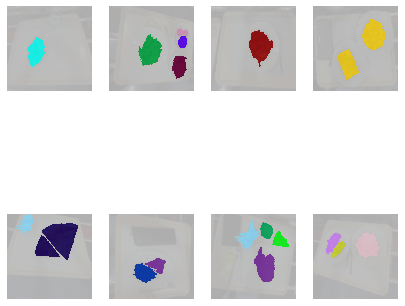

In [22]:
dataloaders.train.show_batch(max_n=8, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

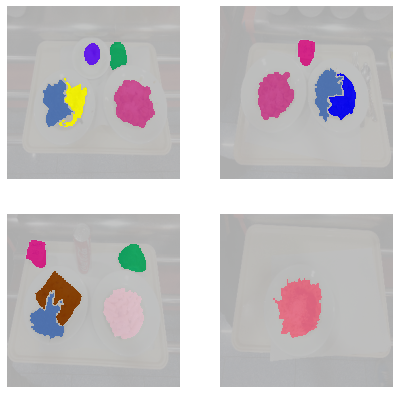

In [23]:
dataloaders.valid.show_batch(max_n=4, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

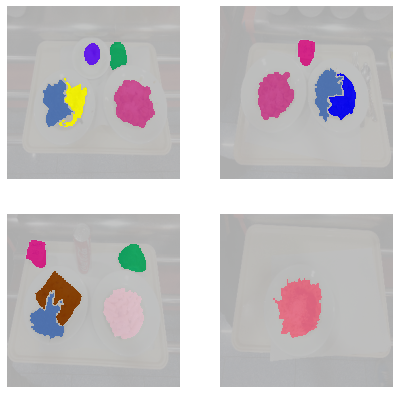

In [24]:
test_dl.show_batch(max_n=4, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

## Metrics

In [25]:
from fastaiMetrics import acc_segmentation, MIOU

classes_index = range(1, len(codes)) #exclude background class at index 0
metrics = [acc_segmentation, DiceMulti, MIOU(classes_index, axis=1)]

## Model

In [26]:
# EarlyStoppingCallback(monitor='miou',patience=50) -> if patience is too high, this may cause error in learner.validate()
modelCallbacks = [ShowGraphCallback]
opt_func = Adam

from fastaiCustomLosses import CombinedLossTunable
# loss_func = CrossEntropyLossFlat(weight=lossClassWeights, axis=1)
# loss_func = FocalLossFlat(weight=lossClassWeights, axis=1)
loss_func = CombinedLossTunable()

learner = unet_learner(dataloaders, resnet34, loss_func=loss_func, opt_func=opt_func, metrics=metrics, cbs=modelCallbacks,
                       self_attention=False, act_cls=Mish).to_fp32()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [27]:
#learner.model[0].load_state_dict(torch.load(path_to_drive + 'DiabetesLearning/trainingConfig/resnet34_encoder-food101.h5'), strict=True); #load preTrained from FOOD101

In [28]:
# learner.load(path + 'stage-2-brazilFoods', strict=False)
# learner.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# learner.model.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# test = Learner(dataloaders,resnet34)
# learner.load('stage-2-best')

## Training

SuggestedLRs(valley=5.248074739938602e-05)

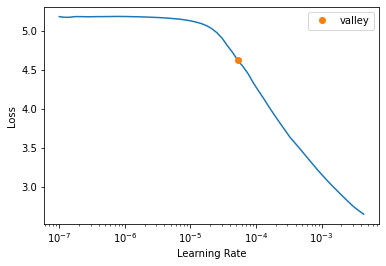

In [29]:
learner.lr_find()

In [37]:
lr = 6e-4
freezeEpochs = 1
unfreezeEpochs = 30
wd = 1e-2
learner.freeze()

epoch,5.72289
train_loss,0.08701
raw_loss,0.12031
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.86403
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,3e-05


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▁▂▁▂▂▃▄█▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▃▃▃
raw_loss,▁▁▂▄▂▂▄█▃▂▂▂▁▃▂▂▁▆▃▂▂▂▃▂▁▁▆▃▂▂▃▂▃▄▅▂▁▂▁▆
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▃▄▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,█▇▆▅▃▂▁████▇▇▇▆▆▅▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▃▄▆▇█▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄


epoch,train_loss,valid_loss,acc_segmentation,dice_multi,miou,time
0,0.091281,0.195651,0.747762,0.518368,0.430737,01:48


/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)


Better model found at epoch 0 with miou value: 0.4307369558409547.


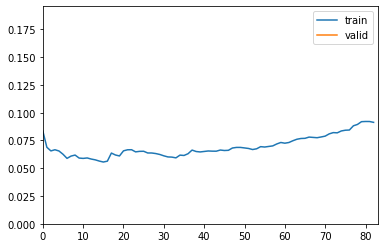

epoch,train_loss,valid_loss,acc_segmentation,dice_multi,miou,time
0,0.071296,0.126271,0.843285,0.678427,0.609927,01:42
1,0.061468,0.130255,0.843157,0.683797,0.611554,01:42
2,0.058595,0.128097,0.843976,0.684849,0.615189,01:40
3,0.058890,0.136614,0.835909,0.669968,0.591734,01:41
4,0.057587,0.133794,0.827800,0.660403,0.594203,01:40
5,0.067843,0.140748,0.826890,0.642190,0.564011,01:40
6,0.070119,0.137379,0.834869,0.644721,0.570137,01:40
7,0.072036,0.135571,0.826187,0.682939,0.602208,01:40
8,0.085548,0.141495,0.828137,0.655787,0.580226,01:41
9,0.075022,0.134809,0.820624,0.677413,0.575928,01:39


Better model found at epoch 0 with miou value: 0.6099271512670855.


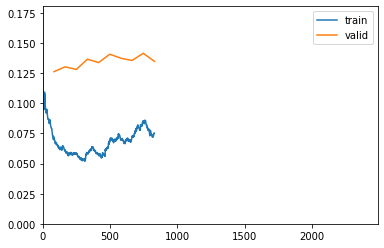

Better model found at epoch 1 with miou value: 0.611554281136404.
Better model found at epoch 2 with miou value: 0.6151889327407127.


In [ ]:
run = wandb.init(project="diabetesLearning-unimib16") # track machine learning experiment
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='miou', fname='stage-1-combinedLossTunable',with_opt=True), GradientAccumulation(n_acc=gradientAcc)]
# learner.fit_one_cycle(epochs, slice(lr), pct_start=0.8, wd=wd, cbs=fitCallbacks)
# learner.fit_flat_cos(epochs, slice(lr), wd=wd,cbs=fitCallbacks)
learner.fine_tune(unfreezeEpochs, base_lr=lr, freeze_epochs=freezeEpochs, pct_start=0.3, wd=wd, cbs=fitCallbacks)
run.finish()

## Fine-tunning (optional)

In [ ]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [ ]:
# learner = unet_learner(dataloaders, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=metrics, cbs=callbacks,
#                        wd_bn_bias=True).to_fp16()
# learner.load('stage-1-best')


In [ ]:
learner.unfreeze()
# learner.lr_find()

In [ ]:
lrs = slice(lr/400,lr/4)
epochs = 50
wd = 1e-2

epoch,train_loss,valid_loss,acc_segmentation,dice_multi,miou,time
0,0.443479,0.832528,0.532327,0.256014,0.118144,02:15
1,0.419501,0.806147,0.544782,0.271664,0.126363,02:14
2,0.403940,0.828603,0.533374,0.258908,0.119813,02:15
3,0.397915,0.831908,0.537469,0.274561,0.128003,02:15
4,0.402978,0.828310,0.528577,0.270263,0.125514,02:15
5,0.376559,0.835561,0.534543,0.280300,0.130349,02:14
6,0.383563,0.833254,0.534618,0.282890,0.132608,02:16
7,0.342848,0.858938,0.526259,0.275354,0.127085,02:15
8,0.356883,0.832172,0.540758,0.299238,0.140044,02:15
9,0.331411,0.850221,0.529885,0.289319,0.134324,02:16


/content/drive/My Drive/Colab Notebooks/DiabetesLearning/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)


Better model found at epoch 0 with acc_segmentation value: 0.5323270559310913.


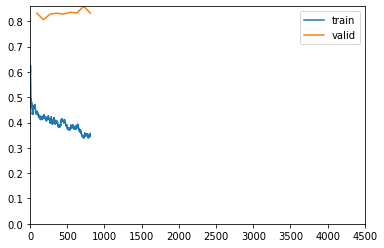

Better model found at epoch 1 with acc_segmentation value: 0.5447819232940674.
No improvement since epoch 1: early stopping


epoch,46
train_loss,0.33141
raw_loss,0.16842
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
wd_1,0.01
sqr_mom_1,0.99


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,▇█▅▅▅▄▅▄▄▃▄▃▃▃▂▂▃▃▄▂▂▃▃▂▂▂▃▂▂▂▃▂▁▁▂▂▁▂▂▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,███████████████████████████████▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
#run = wandb.init(project="diabetesLearning") # track machine learning experiment
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='acc_segmentation', fname='stage-2-best',with_opt=True),GradientAccumulation(n_acc=gradientAcc)]
# learner.fit_one_cycle(epochs, lrs, pct_start=0.3, wd=wd, cbs=fitCallbacks)
learner.fit_flat_cos(epochs, lrs, wd=wd, cbs=fitCallbacks)
run.finish()

In [ ]:
# learner.load('stage-2-best')
# learner.save('stage-2-size350-bestEpoch')

## FastAI Validation

In [62]:
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

#### fastai metrics names
metricsNames = ["Loss", "Acc_Segmentation", "Dice", "Miou"]

#### add iou per class if you want
from fastaiMetrics import IOU
iouPerClass = []
for x in range(1,len(codes)): iouPerClass.append(IOU(x, codes[x], axis=1, ignore_index=0)) #ignore background idx 0
learner.metrics = metrics + iouPerClass
metricsNames += ["Iou " + codes[x] for x in range(1,len(codes))]

#### LOAD ONLY IF NECESSARY
# learner = unet_learner(dataloaders, resnet34, metrics=metrics+iouPerClass)
# learner.load('stage-1-best')

In [63]:
#### check if model overfits ####
trainset = tuple(zip(metricsNames,learner.validate(dl=dataloaders.train)))

#### validate validset ####
validset = tuple(zip(metricsNames,learner.validate(dl=dataloaders.valid)))

"Trainset", trainset, "Validset", validset

/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)


('Trainset',
 (('Loss', 0.021554680541157722),
  ('Acc_Segmentation', 0.9156366586685181),
  ('Dice', 0.8892295947265111),
  ('Miou', 0.8519189159458779),
  ('Iou arancia', 0.9024555434799729),
  ('Iou arrosto', 0.7930996557526698),
  ('Iou arrosto_di_vitello', 0.8418284835393506),
  ('Iou banane', 0.9378534020489494),
  ('Iou bruscitt', 0.8583135780266492),
  ('Iou budino', 0.936294761692543),
  ('Iou carote', 0.9122577294045544),
  ('Iou cavolfiore', 0.6740864236470959),
  ('Iou cibo_bianco_non_identificato', 0.66485890880292),
  ('Iou cotoletta', 0.9515952960797506),
  ('Iou crema_zucca_e_fagioli', 0.9390180163561459),
  ('Iou fagiolini', 0.9210088725436648),
  ('Iou finocchi_gratinati', 0.7748312211808286),
  ('Iou finocchi_in_umido', 0.6352039696131384),
  ('Iou focaccia_bianca', 0.9027963529548272),
  ('Iou guazzetto_di_calamari', 0.896063154105274),
  ('Iou insalata_2_(uova_mais', None),
  ('Iou insalata_mista', 0.887379949781638),
  ('Iou lasagna_alla_bolognese', 0.956178749554

In [64]:
#### validate testset ####
# learner.dls.valid = test_dl
testset = tuple(zip(metricsNames,learner.validate(dl=test_dl)))
"Testset", testset

/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)


('Testset',
 (('Loss', 0.06633887439966202),
  ('Acc_Segmentation', 0.8587161302566528),
  ('Dice', 0.7019134755359153),
  ('Miou', 0.6381683052496502),
  ('Iou arancia', 0.889442954870073),
  ('Iou arrosto', 0.7359776661083194),
  ('Iou arrosto_di_vitello', 0.33124119608437497),
  ('Iou banane', 0.7435699680740395),
  ('Iou bruscitt', 0.8322412160287745),
  ('Iou budino', 0.781494764945237),
  ('Iou carote', 0.8907502656905547),
  ('Iou cavolfiore', 0.303891230720499),
  ('Iou cibo_bianco_non_identificato', 0.28201426630434784),
  ('Iou cotoletta', 0.7712993938964421),
  ('Iou crema_zucca_e_fagioli', 0.0),
  ('Iou fagiolini', 0.902075592087978),
  ('Iou finocchi_gratinati', 0.47507909767021406),
  ('Iou finocchi_in_umido', 0.08174291232761997),
  ('Iou focaccia_bianca', 0.0),
  ('Iou guazzetto_di_calamari', 0.8321858176648189),
  ('Iou insalata_2_(uova_mais', None),
  ('Iou insalata_mista', 0.7907689318356762),
  ('Iou lasagna_alla_bolognese', 0.92419860089919),
  ('Iou mandarini', 0.

In [ ]:
dl = dataloaders.valid

/content/drive/MyDrive/Colab Notebooks/DiabetesLearning/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)


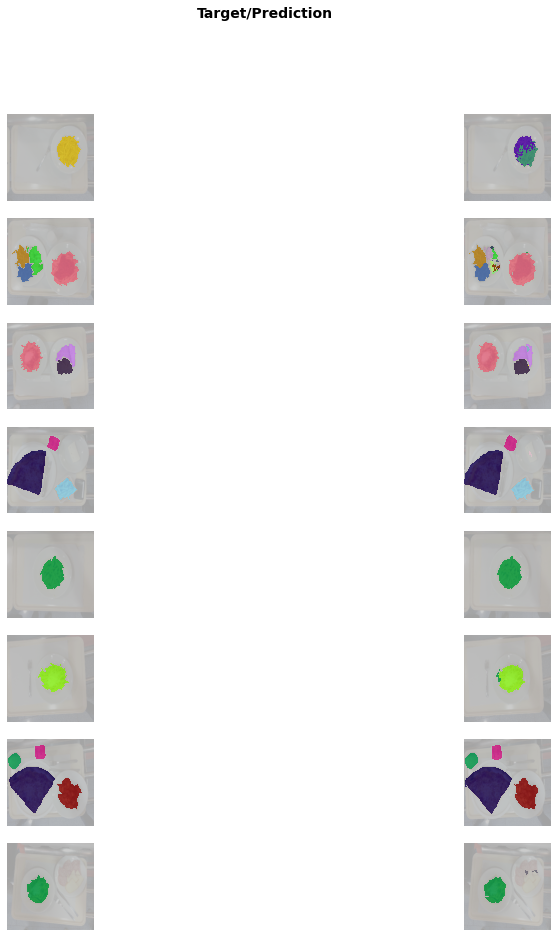

In [ ]:
learner.show_results(dl=dl, figsize=(15,15), max_n=40, cmap=cmap, norm=norm,alpha=0.8)

In [ ]:
# interp = Interpretation.from_learner(learner, dl=test_dl)
# losses,idxs = interp.top_losses()
# interp.plot_top_losses(4, figsize=(15,11), cmap=cmap, norm=norm)

In [ ]:
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#interp.most_confused(min_val=10)

## Sklearn Validation

In [ ]:
from sklearnMetrics import Metrics
void_code = 0
metricsObject = Metrics(codes, [void_code])
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

# LOAD ONLY IF NECESSARY
# learner = unet_learner(dataloaders, resnet34, metrics=metrics)
# learner.load('stage-1-best')

In [ ]:
#input, probabilities, groundTruth, decoded, losses = learner.get_preds(dl=dl,  with_input=True, with_loss=True, with_decoded=True, act=F.softmax) #inputs, preds, groundTruth, losses
input, probabilities, groundTruth, decoded = learner.get_preds(dl=dl,  with_input=True, with_loss=False, with_decoded=True, act=F.softmax) #inputs, preds, groundTruth, losses

/content/drive/MyDrive/Colab Notebooks/DiabetesLearning/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)
/usr/local/lib/python3.7/dist-packages/fastai/learner.py:255: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res[pred_i] = act(res[pred_i])


In [ ]:
print(metricsObject.getAccuracy(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.8558042560882293


In [ ]:
print(metricsObject.get_f1Score(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.858181984127178


In [ ]:
confusionMatrix = metricsObject.getConfusionMatrix(decoded.flatten().numpy(), groundTruth.flatten().numpy(), plot=False)

In [ ]:
mostConfused = metricsObject.mostConfused(confusionMatrix, numberOfConfusions=4)

print("Actual", "   Predicted", "   Wrong pixels\n")
mostConfused

Actual    Predicted    Wrong pixels



[['pasta_cozze_e_vongole', 'pasta_sugo_vegetariano', 19472],
 ['cotoletta', 'pane', 15399],
 ['pasta_mare_e_monti', 'pasta_cozze_e_vongole', 12517],
 ['pasta_tonno_e_piselli', 'pane', 8985]]

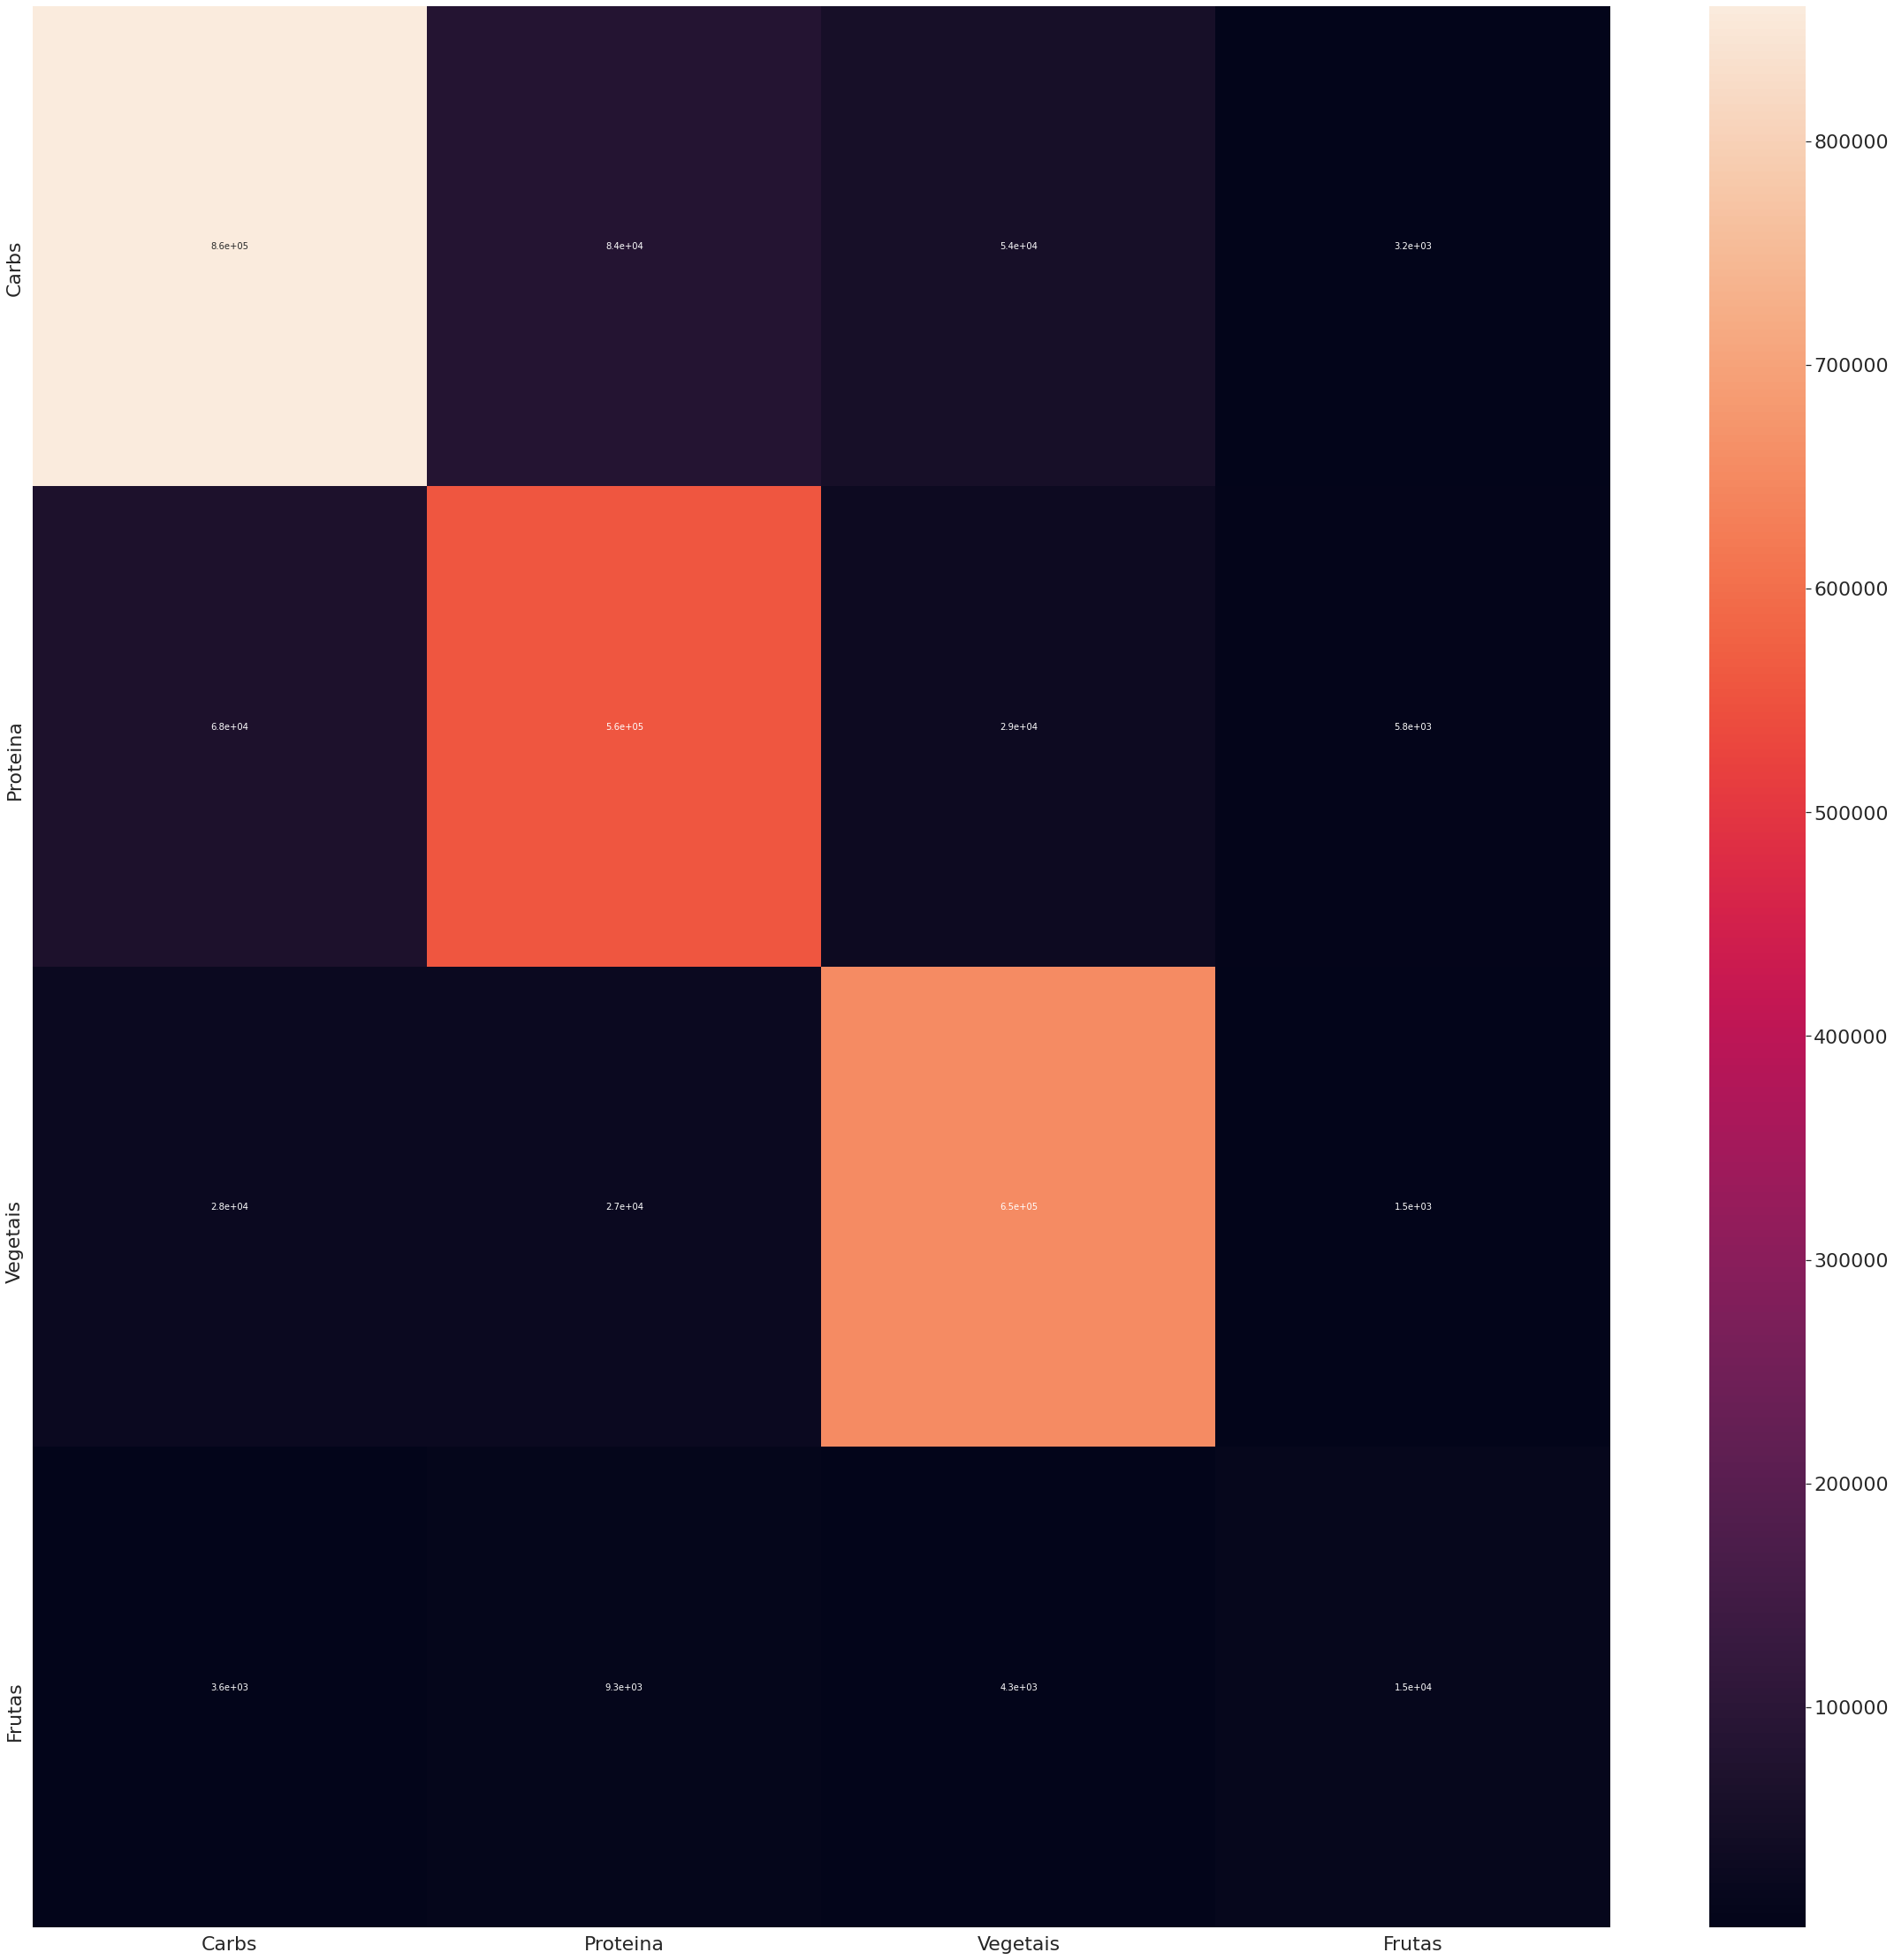

In [ ]:
#plot confusion matrix (take some time, too big the matrix). Think in a better way to visualize (check for most confuseds)

metricsObject.plotConfusionMatrix(confusionMatrix, font_scale=2, removeDiagonal=False)

In [ ]:
print(metricsObject.getClassificationReport(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

                                         precision    recall  f1-score   support

                                arancia       0.89      0.86      0.88     18350
                                arrosto       0.78      0.79      0.79     52467
                     arrosto_di_vitello       0.60      0.29      0.39     12217
                                 banane       0.94      0.69      0.79     13909
                               bruscitt       0.97      0.83      0.90     24663
                                 budino       0.93      0.77      0.84     46610
                                 carote       0.94      0.93      0.94    130186
                             cavolfiore       0.42      0.27      0.33      8095
           cibo_bianco_non_identificato       0.31      0.21      0.25      4168
                              cotoletta       0.93      0.80      0.86    150274
                  crema_zucca_e_fagioli       0.00      1.00      0.00         0
                           

## Check some particular image details

In [ ]:
from collections import OrderedDict

id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

def getFoodsInImage(tensor, removeVoid=False):
    foods, counts = np.unique(tensor,return_counts=True)
    if removeVoid:
        counts = np.delete(counts, 0) #tira o void na posicao 0 do array
        foods = np.delete(foods, 0) #tira o void na posicao 0 do array
    
    foodNames = []
    print(f'Numero de alimentos: {len(foods)}')
    for food in foods:
        foodNames = np.append(foodNames,id2name[food])
    dictCounts = dict(zip(foodNames, counts))
    dictCounts = OrderedDict(sorted(dictCounts.items(), key=lambda x: x[1], reverse=True))
    print(dictCounts)
    return dictCounts

def getMostAppearances(foodCountsDict, k = 3):
    sortedDict = OrderedDict(sorted(foodCountsDict.items(), key=lambda x: x[1], reverse=True))
    topKDict = {}
    for count, (key, v) in enumerate(foodCountsDict.items()):
        if count == k:
            break
        elif key != "NaoAlimento":
            topKDict[key] = v
        else:
            k += 1 # increment k if find NaoAlimento in the first positions
    
    return topKDict
        


Original                           Mask                        Prediction


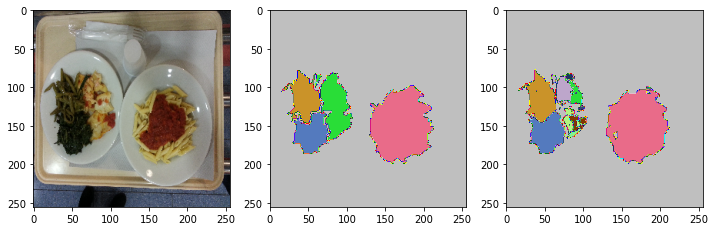

In [ ]:
idx = 1
fig = plt.figure(figsize=(12,12))

# denorm to original image
rawImage = copy(input[idx])

nrm = Normalize.from_stats(*imagenet_stats)
image = nrm.decode(rawImage) #fastai version 2.3.1 needs two denorms!!!! FUCK YOU FASTAI!!!
image = nrm.decode(image).clamp(0,1).squeeze().permute(1,2,0) # denorm image from imagenet stats

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(image)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(groundTruth[idx], cmap=cmap, norm=norm)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(decoded[idx], cmap=cmap, norm=norm)

print("Original","                          Mask", "                       Prediction")

In [ ]:
print("Ground truth\n")
sample = groundTruth[idx]
gtDictCounts = getFoodsInImage(sample)


Ground truth

Numero de alimentos: 5
OrderedDict([('void', 54058), ('pasta_sugo', 5855), ('pesce_(filetto', 2270), ('fagiolini', 1712), ('spinaci', 1641)])


In [ ]:
print("Prediction\n")
sample = decoded[idx]
decodedDictCounts = getFoodsInImage(sample)


Prediction

Numero de alimentos: 17
OrderedDict([('void', 54698), ('pasta_sugo', 5692), ('spinaci', 1706), ('fagiolini', 1681), ('pesce_2_(filetto', 637), ('pesce_(filetto', 338), ('finocchi_gratinati', 292), ('torta_salata_(alla_valdostana', 250), ('guazzetto_di_calamari', 82), ('cibo_bianco_non_identificato', 80), ('patate/pure_prosciutto', 47), ('pasta_zafferano_e_piselli', 12), ('cotoletta', 8), ('mandarini', 4), ('torta_salata_3', 4), ('pizza', 3), ('scaloppine', 2)])


In [ ]:
# get low prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)
lowProbs = []
lowProbsIdx = []

mask = bestProbs < 0.5
lowProbsIdx = bestProbsIdx[mask]
lowProbDictCounts = getFoodsInImage(lowProbsIdx)

print("\nPercentual de pixeis com baixa probabilidade\n")
for key, value in lowProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 17
OrderedDict([('void', 813), ('finocchi_gratinati', 283), ('torta_salata_(alla_valdostana', 249), ('pasta_sugo', 241), ('pesce_(filetto', 151), ('pesce_2_(filetto', 149), ('cibo_bianco_non_identificato', 80), ('spinaci', 64), ('fagiolini', 51), ('guazzetto_di_calamari', 47), ('patate/pure_prosciutto', 47), ('pasta_zafferano_e_piselli', 12), ('cotoletta', 8), ('mandarini', 4), ('torta_salata_3', 4), ('pizza', 3), ('scaloppine', 2)])

Percentual de pixeis com baixa probabilidade

void 1.49 %
finocchi_gratinati 96.92 %
torta_salata_(alla_valdostana 99.60 %
pasta_sugo 4.23 %
pesce_(filetto 44.67 %
pesce_2_(filetto 23.39 %
cibo_bianco_non_identificato 100.00 %
spinaci 3.75 %
fagiolini 3.03 %
guazzetto_di_calamari 57.32 %
patate/pure_prosciutto 100.00 %
pasta_zafferano_e_piselli 100.00 %
cotoletta 100.00 %
mandarini 100.00 %
torta_salata_3 100.00 %
pizza 100.00 %
scaloppine 100.00 %


In [ ]:
# get high prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)

mask = bestProbs > 0.5
highProbsIdx = bestProbsIdx[mask]
highProbDictCounts = getFoodsInImage(highProbsIdx)

print("\nPercentual de pixeis com alta probabilidade\n")
for key, value in highProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 9
OrderedDict([('void', 53885), ('pasta_sugo', 5451), ('spinaci', 1642), ('fagiolini', 1630), ('pesce_2_(filetto', 488), ('pesce_(filetto', 187), ('guazzetto_di_calamari', 35), ('finocchi_gratinati', 9), ('torta_salata_(alla_valdostana', 1)])

Percentual de pixeis com alta probabilidade

void 98.51 %
pasta_sugo 95.77 %
spinaci 96.25 %
fagiolini 96.97 %
pesce_2_(filetto 76.61 %
pesce_(filetto 55.33 %
guazzetto_di_calamari 42.68 %
finocchi_gratinati 3.08 %
torta_salata_(alla_valdostana 0.40 %


## Predictions of new input data

In [ ]:
# always load it!

learner = unet_learner(dataloaders, resnet34, self_attention=False, act_cls=Mish)
learner.load('stage-1-best')

In [ ]:
#input should be a PIL object

index = 50
img = dataloaders.valid_ds[index][0]

# img_pil = Image.open("3.jpg")
# img = np.asarray(img_pil.resize((400,400)))

pred = learner.predict(img)

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(pred[0],cmap=cmap)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img)

foods = getFoodsInImage(pred[0])
k = 3
mostAppear = list(getMostAppearances(foods, k=k).keys())
print('\n{} principais alimentos:'.format(k),mostAppear)